In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D,concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, concatenate, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
img_size = 240      #original img size is 240*240
smooth = 1 
num_of_aug = 1
num_epoch = 10
pul_seq = 'Flair'
sharp = False       # sharpen filter

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis, 2 = tumor core, 4 = ET, 5 = complete tumor

In [46]:
import glob
def create_data(src, mask, label=False, resize=(155,img_size,img_size)):
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        #img = trans.resize(img, resize, mode='constant')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
        for slice in range(110,120):     #choose the slice range
            img_t = img[slice,:,:]
#             img_t = img_t.reshape((1,)+img_t.shape)
#             img_t = img_t.reshape((1,)+img_t.shape)   #become rank 4
            img_t = np.expand_dims(img_t, axis=2)
            img_t = np.expand_dims(img_t, axis=0)
            img_g = augmentation(img_t, num_of_aug)
            for n in range(img_g.shape[0]):
                imgs.append(img_g[n,:,:,:])
        break
    name = 'sample_y_'+ str(img_size) + '_' +str(label_num) if label else 'sample_x_'+ str(img_size) + pul_seq
    np.save(name, np.array(imgs).astype('float32'))  # save at home
    print('Saved', len(files), 'to', name)

In [48]:
def augmentation(scans, n):          #input img must be rank 4 
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=25,
        zoom_range=False)
    i = 0
    scans_g = scans.copy()
    for batch in datagen.flow(scans, batch_size=1, seed=1000): 
        scans_g = np.vstack([scans_g,batch])
        i += 1
        if i == n:
            break

    return scans_g

In [50]:
create_data('./BRATS2015_Training/HGG/', '**/*{}*.mha'.format(pul_seq), label=False, resize=(155,img_size,img_size))
create_data('./BRATS2015_Training/HGG/', '**/*OT*.mha', label=True, resize=(155,img_size,img_size))

Processing--- **/*Flair*.mha
Saved 220 to sample_x_240Flair
Processing--- **/*OT*.mha
Saved 220 to sample_y_240_5


In [51]:
x = np.load('./sample_x_{}{}.npy'.format(img_size,pul_seq))
y = np.load('./sample_y_{}_{}.npy'.format(img_size,label_num))

In [52]:
x.shape

(20, 240, 240, 1)

In [53]:
y.shape

(20, 240, 240, 1)

In [64]:
np.sum(y)

0.0

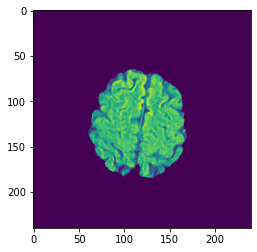

In [65]:
plt.imshow(x[9,:,:,0])